This notebook contains the experiments done with the `fast.ai` library. Reasons - 

- Extremely fast
- Incorporates modern deep learning practices (like one cycle policy, learning rate annealing and so on)

The training time has been reduce to just **5 seconds** with same architecture (ResNet50). This is promising I think. I ran the experiments on a GCP `n1-standard-4` machine type (with Tesla P4). The previous experiments (mixed precision policy) were also run on the same machine and the training time was 5-7 times more on average. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [7]:
!pwd

/home/jupyter/histology_classifier/Sayak_Notebooks


In [12]:
!ls /home/jupyter/histology_classifier/data_chec_resized

Bladder  Brain	dat.csv  Kidney  LI  Liver  Lung  pool	SI  Skin


In [54]:
path = '/home/jupyter/histology_classifier/data_chec_resized/pool'
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(max_lighting=None, p_lighting=0.0), valid_pct=0.2,
                                   size=(256, 192), bs=16).normalize(imagenet_stats)

> The above function creates a `ImageDataBunch` object from the `labels.csv` file (`dat.csv) (which all the fast.ai models need for training (computer vision)) and at the same time does the following - 
- Reads the image data as specified in the .csv file
- Creates the labels
- Applies data augmentation
- Prepares the validation set
- Normalizes the pixels

Appreciation does not harm. Does it? 

The following help function to show the training data is simply amazing. 

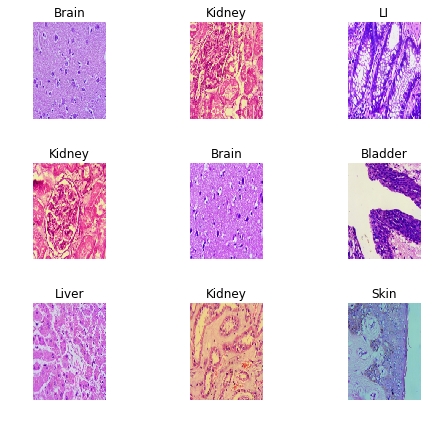

In [55]:
data.show_batch(rows=3, figsize=(7,6))

In [49]:
print(data.classes)
len(data.classes),data.c

['Bladder', 'Brain', 'Kidney', 'LI', 'Liver', 'Lung', 'SI', 'Skin']


(8, 8)

## Initial experiments with ResNet34

In [56]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# The magic of one_cycle_policy
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.506651,2.150322,0.812500,00:01
1,2.173701,1.501631,0.500000,00:01
2,1.837279,0.803027,0.187500,00:01
3,1.458350,0.493972,0.187500,00:01
4,1.227995,0.328905,0.062500,00:01
5,1.022616,0.300734,0.062500,00:01
6,0.874948,0.295404,0.125000,00:01
7,0.761330,0.302977,0.125000,00:01
8,0.664965,0.313872,0.125000,00:01
9,0.592551,0.315021,0.125000,00:01


> Look at the training time. 

In [57]:
learn.save('stage-1')

In [58]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Where the model is getting confused. Extremely helpful in interpreting things. 

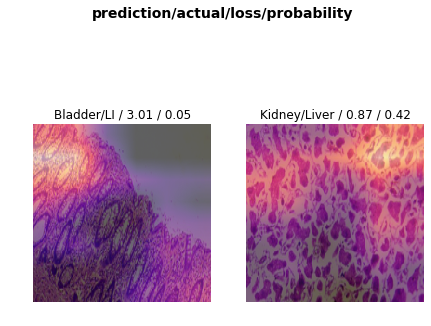

In [62]:
interp.plot_top_losses(2, figsize=(7,6))

**Fine-tuning** the model. 

In [64]:
learn.unfreeze()

In [65]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.100355,0.881781,0.187500,00:01


In [66]:
learn.load('stage-1');

In [74]:
# Differential learning rates
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.855039,0.513042,0.187500,00:01
1,0.987820,0.475012,0.187500,00:01


## Now comes RestNet50

In [75]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.torch/models/resnet50-19c8e357.pth
102502400it [00:03, 28923661.82it/s]


Leslie Smith's learning rate finding technique as discussed in the paper: https://arxiv.org/abs/1506.01186

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


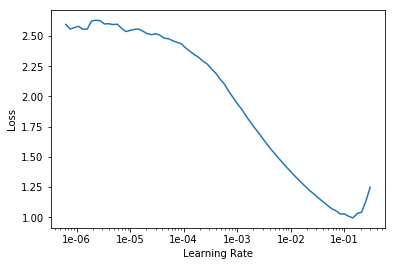

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.507110,1.831589,0.687500,00:01
1,1.730457,0.766792,0.187500,00:01
2,1.184705,0.307797,0.062500,00:01
3,0.900783,0.217640,0.062500,00:01
4,0.721434,0.198750,0.062500,00:01
5,0.585402,0.205142,0.062500,00:01
6,0.497368,0.219526,0.062500,00:01
7,0.426015,0.237854,0.062500,00:01
8,0.368903,0.252960,0.062500,00:01
9,0.322613,0.269736,0.062500,00:01


In [78]:
learn.save('stage-1-50')

In [79]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.022251,0.269188,0.062500,00:02
1,0.068480,0.244705,0.062500,00:01
2,0.059255,0.241659,0.062500,00:01


> Speed has a name and it is called **fast.ai**. 